#Generative models
In this Lab we will be experimenting with

- Convolutional autoencoders
- Latent space visualization adn interpolation
- Upsampling techniques
- Variational autoencoders
- Deep Convolutional GANs (DCGANs)

If you want to experiemnt with Denoising Autoencoders, revisit Lab 3 (task 5):
https://github.com/aivclab/dlcourse/blob/master/Lab3_FunWithMNIST.ipynb

**Before we start - remember to set runtime to GPU**

**NOTE:** In case you have trouble running Keras/TensorFlow in Colab, try one of the following:

In [0]:
# Try this
#!pip install --upgrade tensorflow==1.8.0

# ... or this
%tensorflow_version 1.x

# Check TensorFlow version
#import tensorflow as tf
#print(tf.__version__)

##1. Download the MNIST dataset
As usual:

In [3]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras import backend as K

num_classes = 10

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

# Pre-process inputs
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# Convert class indices to one-hot vectors
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

11493376/11490434 [==============================] - 1s 0us/step


In [4]:
# Input shape: 28 x 28 x 1 = image with one color channel
print('input_shape :',input_shape)

# Pre-process inputs
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# to_categorical converts class indices to one-hot vectors
print('y_train shape:', y_train.shape)

input_shape : (28, 28, 1)
x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
y_train shape: (60000, 10)


##2. Task 1: Convolutional Autoencoder
Here is an example of a Convolutional Autoencoder (CAE) for MNIST.

**Note:** There are many ways to implement CAEs. This one is designed to map the input image down to a 2D latent space, so that you can plot the latent vectors in 2D. Also note how we define the encoder and the decoder separately and combine them afterwards to form the final CAE model.


###2.1 Your task
The shape of the decoder's output should match the input shape (28x28x1), but it doesn't. Try for yourself. Your task is to fix this problem by modifying this line of code:

```
decoded = Conv2D(1, kernel_size=(3, 3), padding='same', activation='sigmoid')(x)
```


In [5]:
from keras.layers import Input, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from keras.models import Model
from keras.layers import UpSampling2D, ZeroPadding2D, Conv2DTranspose, Reshape

# Number of latent dimensions
latent_dim = 2

# Encoder (convolutional base)
inputs = Input(shape=(28, 28, 1))
x = ZeroPadding2D(padding=(2, 2))(inputs)
x = Conv2D(8, kernel_size=(3, 3), strides=(2,2), activation='relu', padding='same')(x)
x = Conv2D(16, kernel_size=(3, 3), strides=(2,2), activation='relu', padding='same')(x)
x = Conv2D(32, kernel_size=(3, 3), strides=(2,2), activation='relu', padding='same')(x)

# shape info needed to build decoder model
shape = K.int_shape(x)

x = Flatten()(x)
encoded = Dense(latent_dim)(x)
encoder = Model(inputs, encoded)
encoder.summary()
print(("shape of encoded", K.int_shape(encoded)))

# Decoder (upsamling)
encoding = Input(shape=(1, 1, latent_dim))
x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(encoding)
x = Reshape((shape[1], shape[2], shape[3]))(x)
x = Conv2DTranspose(32, (3,3), strides=(2,2), padding='same')(x)
x = Conv2DTranspose(16, (3,3), strides=(2,2), padding='same')(x)
x = Conv2DTranspose(8, (3,3), strides=(2,2), padding='same')(x)
decoded = Conv2D(1, kernel_size=(3, 3), padding='same', activation='sigmoid')(x) # Fix this line !!!
decoder = Model(encoding, decoded)
decoder.summary()
print(("shape of decoded", K.int_shape(decoded)))

x = encoder(inputs)
predictions = decoder(x)
autoencoder = Model(input=inputs, output=predictions)




Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 8)         80        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 16)          1168      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 32)          4640      
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("mo...)`


###Solution

In [6]:
from keras.layers import Input, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from keras.models import Model
from keras.layers import UpSampling2D, ZeroPadding2D, Conv2DTranspose, Reshape

latent_dim = 2

# Encoder (convolutional base)
inputs = Input(shape=(28, 28, 1))
x = ZeroPadding2D(padding=(2, 2))(inputs)
x = Conv2D(8, kernel_size=(3, 3), strides=(2,2), activation='relu', padding='same')(x)
x = Conv2D(16, kernel_size=(3, 3), strides=(2,2), activation='relu', padding='same')(x)
x = Conv2D(32, kernel_size=(3, 3), strides=(2,2), activation='relu', padding='same')(x)
# shape info needed to build decoder model
shape = K.int_shape(x)
x = Flatten()(x)
encoded = Dense(latent_dim)(x)
encoder = Model(inputs, encoded)
encoder.summary()
print(("shape of encoded", K.int_shape(encoded)))

# Decoder (upsamling)
encoding = Input(shape=(1, 1, latent_dim))
x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(encoding)
x = Reshape((shape[1], shape[2], shape[3]))(x)
x = Conv2DTranspose(32, (3,3), strides=(2,2), padding='same')(x)
x = Conv2DTranspose(16, (3,3), strides=(2,2), padding='same')(x)
x = Conv2DTranspose(8, (3,3), strides=(2,2), padding='same')(x)
decoded = Conv2D(1, kernel_size=(5, 5), padding='valid', activation='sigmoid')(x)
decoder = Model(encoding, decoded)
decoder.summary()
print(("shape of decoded", K.int_shape(decoded)))

x = encoder(inputs)
predictions = decoder(x)
autoencoder = Model(input=inputs, output=predictions)

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 8)         80        
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 8, 8, 16)          1168      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 4, 4, 32)          4640      
_________________________________________________________________
flatten_2 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 1026

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("mo...)`


###2.2 Questions:
1. What does the `ZeroPadding2D` layer do?
2. What is the shape of the data before and after zero padding? (Note: for downsampling and upsampling it is more convenient if the shape of the data is a power of 2).
3. What is the purpose of the `Reshape`layer in the decoder?


###Answers
1. It extends the size of the input image by two pixels on all sides from 28x28x1 to 32x32x1.
2. Before 28x28x1 and after 32x32x1. We prefer 32 over 28 because it is a power of 2 (during downsampling and upsampling the shapes are easily calculated as 32->16->8->4->8->16->32).
3. The input to the decoder is a 2-dimensional vector (you can cahnge that by setting latent_dim), which is transformed to 512 dimensional vector through a dense (fully connected) layer. This shape cames from that last feature map of the encoder, which is a 4x4x32. The purpose of the Reshape layer is to convert the 512-D vector into a a 4x4x32 volume, matching tha shape of the last feature map of the encoder (and thereby making the encoder/decoder symmetric).

###2.3 Training
Let's train the autoencoder for 30 epochs (add more epochs to improve results):

In [7]:
autoencoder.compile(optimizer='adam', loss='mse')
history = autoencoder.fit(x_train, x_train, epochs=30, batch_size=256,
               shuffle=True, validation_data=(x_test, x_test), verbose=1)





Train on 60000 samples, validate on 10000 samples
Epoch 1/30





60000/60000 [==============================] - 10s 172us/step - loss: 0.0805 - val_loss: 0.0573
Epoch 2/30
60000/60000 [==============================] - 2s 37us/step - loss: 0.0554 - val_loss: 0.0541
Epoch 3/30
60000/60000 [==============================] - 2s 37us/step - loss: 0.0523 - val_loss: 0.0509
Epoch 4/30
60000/60000 [==============================] - 2s 37us/step - loss: 0.0499 - val_loss: 0.0496
Epoch 5/30
60000/60000 [==============================] - 2s 36us/step - loss: 0.0487 - val_loss: 0.0482
Epoch 6/30
60000/60000 [==============================] - 2s 36us/step - loss: 0.0479 - val_loss: 0.0477
Epoch 7/30
60000/60000 [==============================] - 2s 36us/step - loss: 0.0473 - val_loss: 0.0478
Epoch 8/30
60000/60000 [==============================] - 2s 36us/step - loss: 0.0469 - val_loss: 0.0465
Epoch 9/30
60000/60000 [==============================] - 2s 36us/step - loss: 0.0465 - val_loss: 0

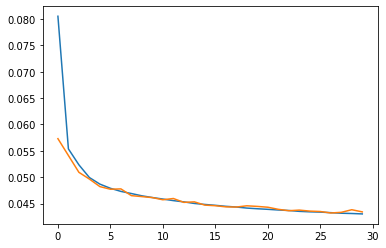

In [8]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

###2.4 Plot the latent space representation
To get some intuition about what our autoencoder has learned, we can plot the latent representation of the training data:

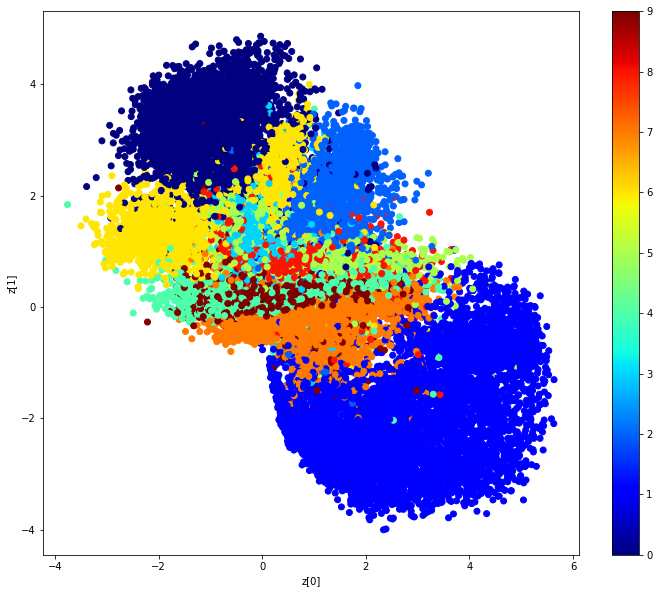

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
mpl.rc('image', cmap='jet')

# Get latent representation
z = encoder.predict(x_train,batch_size=32)

# Plot
plt.figure(figsize=(12, 10))
plt.scatter(z[:, 0], z[:, 1], c=np.argmax(y_train,axis=1))
plt.colorbar()
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.show()

Rather than plotting the latent representation of the training samples, we could also use the CAE to *generate* new samples. We do this by generating latent vectors that span a 2D grid (defined by `grid_x` and `grid_y` below) and then feed each latent vector on the grid into the decoder to generate an image: 

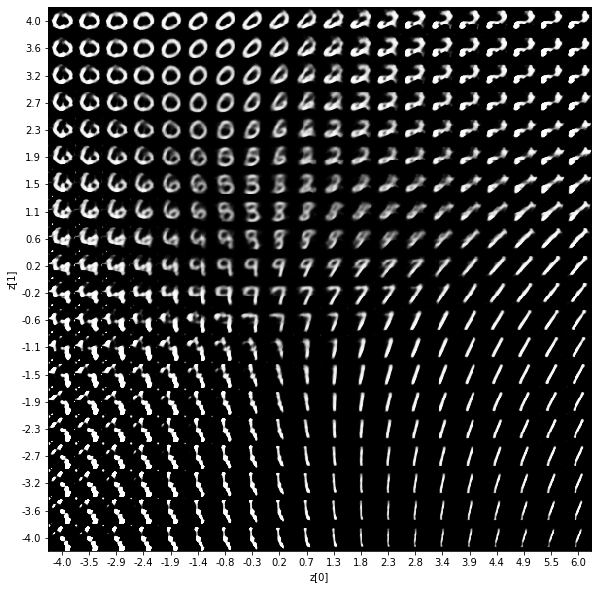

In [10]:
import numpy as np
import matplotlib.pyplot as plt
n = 20
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates corresponding to the 2D plot
# of digit classes in the latent space
grid_x = np.linspace(-4, 6, n)        # Task : Set range according to your latent representation
grid_y = np.linspace(-4, 4, n)[::-1]  # Task : Set range according to your latent representation

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample.reshape(1,1,1,2))
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
                j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
start_range = digit_size // 2
end_range = n * digit_size + start_range + 1
pixel_range = np.arange(start_range, end_range, digit_size)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.imshow(figure, cmap='Greys_r')

**Sub-task:** To get the best result, modify the x and y ranges (`grid_x` and `grid_y') so that they approximately match the ranges observed in the previous plot of the training data.

**Solution:** I set the rangs to


```
grid_x = np.linspace(-4, 6, n)        # Task : Set range according to your latent representation
grid_y = np.linspace(-4, 4, n)[::-1]  # Task : Set range according to your latent representation
```

because z[0] seems to go from -4 to 6 and z[1] from -4 to 4, based on the plot above.


###2.5 Question
1. Which digits can the autoencoder generate faithfully, which digits does it have trouble generating? Why?

###Answer
1. May digits are squashed together at the center of the latent space, so these cannot be faithfully reconstructed. The ones that are nicely separated (and can be reconstructed) are 0, 1, 6, 7, and to some extend 2.

###2.6 Encoding, decoding and latent space interpolation
Now that we have trained an autoencoder, we can use it to encode existing images and generate new images (from a latent representation). With the latent representation we can also start doing interpolation between training samples.

Your task is to 

1. Encode an image of a 7 and an image of a 9 (or any other pair if you refer)
2. Decode the encodings to generate reconstructed images
3. Interpolate between the two digits in latent space

In [0]:
# Draw two samples (a 7 and a 9) and display them
y_test_category = np.argmax(y_test,axis=1)
ix7 = np.where(y_test_category==7)[0][1] # Pick a 7
ix9 = np.where(y_test_category==9)[0][1] # Pick a 9
plt.subplot(221);plt.imshow(x_test[ix7,:].squeeze(),cmap='gray')
plt.subplot(222);plt.imshow(x_test[ix9,:].squeeze(),cmap='gray')

# Subtask 1 (encoding):
# Calculate the latent representation of each sample using the encoder
z7 = # encode x_test[ix7,:]
z9 = # encode x_test[ix9,:]

# Subtask 2 (decoding):
# Reconstruct images from the two latent vectors using the decoder
x_hat_7 = # decode z7
x_hat_9 = # decode z9

# Show reconstruction
plt.subplot(223);plt.imshow(x_hat_7.squeeze(),cmap='gray')
plt.subplot(224);plt.imshow(x_hat_9.squeeze(),cmap='gray')

# Subtask 3 (interpolate):
# Just run - no changes required)
N = 8
interp_features = np.zeros((N,latent_dim))
for i in range(latent_dim):
  interp_features[:,i] = np.linspace(z7[0,i].squeeze(),z9[0,i].squeeze(),N)

plt.figure(figsize=(20,6))
for i in range(N):
  x = interp_features[i,:].reshape(1,1,1,latent_dim)
  out = decoder.predict(x)
  plt.subplot(1,N,i+1)
  plt.imshow(out.squeeze(),cmap='gray')  

###Solution

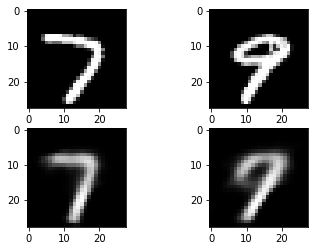

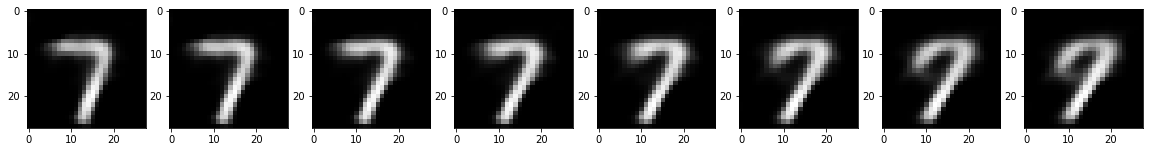

In [11]:
# Draw two samples (a 7 and a 9)
y_test_category = np.argmax(y_test,axis=1)
ix7 = np.where(y_test_category==7)[0][1]
ix9 = np.where(y_test_category==9)[0][1]
plt.subplot(221);plt.imshow(x_test[ix7,:].squeeze(),cmap='gray')
plt.subplot(222);plt.imshow(x_test[ix9,:].squeeze(),cmap='gray')

# Encoding: Calculate the latent representation of each sample
z7 = encoder.predict(x_test[ix7,:].reshape(1,28,28,1))
z9 = encoder.predict(x_test[ix9,:].reshape(1,28,28,1))

# Decoding: Reconstruct images from the two latent vectors
x_hat_7 = decoder.predict(z7.reshape(1,1,1,latent_dim))
x_hat_9 = decoder.predict(z9.reshape(1,1,1,latent_dim))

# Show reconstruction
plt.subplot(223);plt.imshow(x_hat_7.squeeze(),cmap='gray')
plt.subplot(224);plt.imshow(x_hat_9.squeeze(),cmap='gray')

N = 8
interp_features = np.zeros((N,latent_dim))
for i in range(latent_dim):
  interp_features[:,i] = np.linspace(z7[0,i].squeeze(),z9[0,i].squeeze(),N)

plt.figure(figsize=(20,6))
for i in range(N):
  x = interp_features[i,:].reshape(1,1,1,latent_dim)
  out = decoder.predict(x)
  plt.subplot(1,N,i+1)
  plt.imshow(out.squeeze(),cmap='gray')  

**Perspectives:** Given a dataset of facial images, you could use latent space interpolation to generate images like these:

![alt text](https://github.com/davidsandberg/facenet/wiki/20170708-150701-add_smile.png)

##3. Task 2: Implement a CAE from scratch
The purpose of this task is to test if you can implement a CAE from scratch. **I recommend you skip ahead and complete the tasks on variational encoders and GANs first, and then return to this task later**.

Your task is to implement this CAE archtecture for MNIST:

![alt text](https://github.com/aivclab/dlcourse/raw/master/data/Lab9_CAE_architecture.png)

**Explanation**:
- "Conv 1", "Conv 2", "Conv 3", "D Conv 1", "D Conv 2", "D Conv 3", and "D Conv 4" are *all* regular 2D convolutions: [Conv2D](https://keras.io/layers/convolutional/#conv2d).
- "M.P" is short for Max Pooling
- "U.S" is short for upsampling. You must use [UpSampling2D](https://keras.io/layers/convolutional/#upsampling2d) and **not** [Conv2DTranspose](https://keras.io/layers/convolutional/#conv2dtranspose). (What's the difference by the way?)

###Solution

In [30]:
# Encoder (convolutional base)
inputs = Input(shape=(28, 28, 1))
x = Conv2D(16, kernel_size=(3, 3), strides=(1,1), activation='relu', padding='same')(inputs)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Conv2D(8, kernel_size=(3, 3), strides=(1,1), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Conv2D(8, kernel_size=(3, 3), strides=(1,1), activation='relu', padding='same')(x)
latent = MaxPooling2D(pool_size=(2,2),padding='same')(x)

# Decoder (upsamling)
x = Conv2D(8, kernel_size=(3, 3), strides=(1,1), activation='relu', padding='same')(latent)
x = UpSampling2D(size=(2,2))(x)
x = Conv2D(8, kernel_size=(3, 3), strides=(1,1), activation='relu', padding='same')(x)
x = UpSampling2D(size=(2,2))(x)
x = Conv2D(16, kernel_size=(3, 3), strides=(1,1), activation='relu', padding='valid')(x)
x = UpSampling2D(size=(2,2))(x)
decoded = Conv2D(1, kernel_size=(5, 5), strides=(1,1), activation='relu', padding='same')(x)
print(("shape of decoded", K.int_shape(decoded)))

autoencoder = Model(input=inputs, output=decoded)
autoencoder.summary()

('shape of decoded', (None, 28, 28, 1))
Model: "model_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_38 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_95 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_47 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_96 (Conv2D)           (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_48 (MaxPooling (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_97 (Conv2D)           (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_49 (

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


##4. Task 3: Variational Autoencoder
Recall that variational autoencoders (VAE) are designed to learn smooth latent space representation (the problem with traditional autoencoders is that they tend to generate gaps in the latent space, making interpolation impossible). The purpose of this task is to see if this is actually the case in practise.

Below is an implementation of a convolutional VAE.

In [60]:
from keras.layers import UpSampling2D, ZeroPadding2D, Conv2DTranspose, Lambda, Reshape

batch_size = 256
latent_dim = 2

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim))
    return z_mean + K.exp(z_log_sigma) * epsilon

# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=(28, 28, 1),name='encoder_input')
x = ZeroPadding2D(padding=(2, 2))(inputs)
x = Conv2D(8, kernel_size=(3, 3), strides=(2,2), activation='relu', padding='same')(x)
x = Conv2D(16, kernel_size=(3, 3), strides=(2,2), activation='relu', padding='same')(x)
x = Conv2D(32, kernel_size=(3, 3), strides=(2,2), activation='relu', padding='same')(x)
x = Conv2D(64, kernel_size=(3, 3), strides=(2,2), activation='relu', padding='same')(x)
x = Conv2D(64, kernel_size=(3, 3), strides=(2,2), activation='relu', padding='same')(x)

# shape info needed to build decoder model
shape = K.int_shape(x)

# generate latent vector Q(z|X)
x = Flatten()(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

x = Conv2DTranspose(64, (1,1), strides=(2,2), padding='same')(x)
x = Conv2DTranspose(32, (3,3), strides=(2,2), padding='same')(x)
x = Conv2DTranspose(16, (3,3), strides=(2,2), padding='same')(x)
x = Conv2DTranspose(8, (3,3), strides=(2,2), padding='same')(x)
x = Conv2DTranspose(8, (3,3), strides=(2,2), padding='same')(x)
outputs = Conv2D(1, kernel_size=(5, 5), padding='valid', activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
zero_padding2d_10 (ZeroPadding2 (None, 32, 32, 1)    0           encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_148 (Conv2D)             (None, 16, 16, 8)    80          zero_padding2d_10[0][0]          
__________________________________________________________________________________________________
conv2d_149 (Conv2D)             (None, 8, 8, 16)     1168        conv2d_148[0][0]                 
____________________________________________________________________________________________

###4.1 Questions
1. What does the `sampling` function do?
2. The encoder outputs three variables: `[z_mean, z_log_var, z]`. What do they represent?

###Answers
1. The encoder of the VAE generates two vectors, `z_mean` and `z_log_var`, which correspond to the parameters of a Gaussian distribution. The first parameter is the mean, and the second parameter is the logarithm of the variance. The sampling layer simply draws samples from this distribution, which are returned in the tensor `z`. Note that the exponential `K.exp(z_log_sigma)` cancels out the logarithm, such that `K.exp(z_log_sigma)` returns the variance.
2. See answer 1.

###4.2 Loss function
The loss consists of two terms:

- A reconstruction term (or similarity term)
- and a KL divergence term

You can read more about it here: https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf

The KL term is:

![alt text](https://miro.medium.com/max/520/1*uEAxCmyVKxzZOJG6afkCCg.png)

**Sub-task:** Identify the individual terms in the code block below.

In [61]:
from keras.losses import mse
reconstruction_loss = mse(K.flatten(inputs), K.flatten(outputs))
reconstruction_loss *= 28 * 28
kl_loss = K.exp(z_log_var) + K.square(z_mean) - z_log_var/2 - 1
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= 0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')
vae.summary()

Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 28, 28, 1)         0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 61572     
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         29385     
Total params: 90,957
Trainable params: 90,957
Non-trainable params: 0
_________________________________________________________________


###Comments:
`reconstruction_loss` measures the similarity between the input image and the output image, measured as the mean squared error (or the L2 norm).

`kl_loss = K.exp(z_log_var) + K.square(z_mean) - z_log_var - 1` is the KL term with 
- `K.exp(z_log_var)` = variance
- `K.square(z_mean)` = mean value squared
- `z_log_var` = log of the variance

Note that in my solution, I changed

`kl_loss = K.exp(z_log_var) + K.square(z_mean) - z_log_var - 1`

to

`kl_loss = K.exp(z_log_var) + K.square(z_mean) - z_log_var/2 - 1`

because `z_log_var` should be the log of the standard deviation (sigma) and not the log of the variance (sigma squared). To fix this, we use the relationship:

`log(x^2) = 2 * log(x) or equivalently log(x) = log(x^2)/2` 

`kl_loss *= 0.5` determines the weight of the KL term relative to the reconstruction term.



###4.3 Training

In [62]:
num_samples = int(np.floor(x_train.shape[0] / batch_size) * batch_size)
vae.fit(x_train[0:num_samples,:], epochs=30, batch_size=batch_size,
        shuffle=True, verbose=1)

Epoch 1/30
59904/59904 [==============================] - 6s 104us/step - loss: 57.0643
Epoch 2/30
59904/59904 [==============================] - 3s 42us/step - loss: 45.7857
Epoch 3/30
59904/59904 [==============================] - 3s 42us/step - loss: 43.1002
Epoch 4/30
59904/59904 [==============================] - 3s 43us/step - loss: 40.6491
Epoch 5/30
59904/59904 [==============================] - 3s 43us/step - loss: 39.2517
Epoch 6/30
59904/59904 [==============================] - 3s 42us/step - loss: 38.3743
Epoch 7/30
59904/59904 [==============================] - 3s 43us/step - loss: 37.7924
Epoch 8/30
59904/59904 [==============================] - 3s 43us/step - loss: 37.2876
Epoch 9/30
59904/59904 [==============================] - 3s 43us/step - loss: 36.8364
Epoch 10/30
59904/59904 [==============================] - 3s 43us/step - loss: 36.4395
Epoch 11/30
59904/59904 [==============================] - 3s 43us/step - loss: 36.0870
Epoch 12/30
59904/59904 [===============

###4.4 Plot the latent space representation

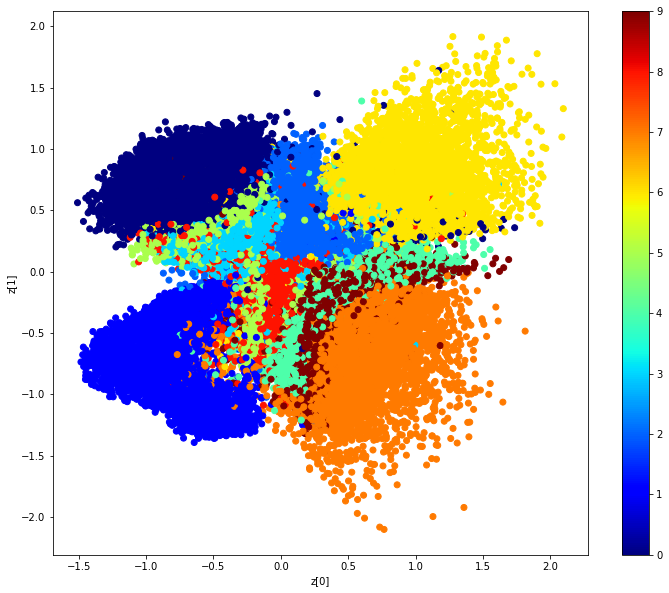

In [63]:
z_mean, _, _ = encoder.predict(x_train[0:num_samples,:],
                                batch_size=batch_size)
import matplotlib as mpl
mpl.rc('image', cmap='jet')
plt.figure(figsize=(12, 10))
plt.scatter(z_mean[:, 0], z_mean[:, 1], c=np.argmax(y_train[0:num_samples,:],axis=1))
plt.colorbar()
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.show()

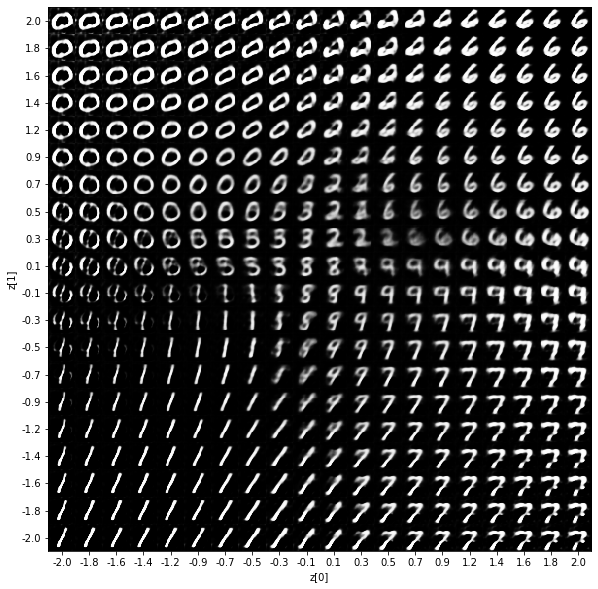

In [65]:
n = 20
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates corresponding to the 2D plot
# of digit classes in the latent space
grid_x = np.linspace(-2, 2, n)
grid_y = np.linspace(-2, 2, n)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
                j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
start_range = digit_size // 2
end_range = n * digit_size + start_range + 1
pixel_range = np.arange(start_range, end_range, digit_size)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.imshow(figure, cmap='Greys_r')

###4.5 Questions
1. What do you think of this latent representation? In terms of quality? In terms of smoothness? Compare to the same plot for the traditional autoencoder.
2. Which digits does the model faithfully reconstruct? Which digits does it have trouble reconstructing? Why?
3. What happens if you set the weight of the KL term to, say 5 (`kl_loss *= 5`), and re-train the model?

###Answers
1. It looks less elongated than the representation obtained with the traditional autoencoder, i.e., the data is more evenly distributed around 0. It looks fairly smooth too. However, the class separation is not mproved.
2. More or less same conclusion as with the traditional autoencoder.
3. The classes will not be separated (try it yourself).

###4.6 Encoding, decoding and latent space interpolation
Like we did for the traditional autoencoder (see section 2.6), your task is to 

1. Encode an image of a 7 and an image of a 9 (**warning - this is trickier than you might think!!!**) 
2. Decode the encodings (to generate reconstructed images)
3. Interpolate between the two digits in latent space

In [66]:
# Draw two samples (a 7 and a 9) and display them
y_test_category = np.argmax(y_test,axis=1)
ix7 = np.where(y_test_category==7)[0][1]
ix9 = np.where(y_test_category==9)[0][1]
plt.subplot(221);plt.imshow(x_test[ix7,:].squeeze(),cmap='gray')
plt.subplot(222);plt.imshow(x_test[ix9,:].squeeze(),cmap='gray')

# Subtask 1 (encoding): Calculate the latent representation of each sample
z7 = # encode x_test[ix7,:]
z9 = # encode x_test[ix9,:]

# Subtask 2 (decoding): Reconstruct images from the two latent vectors
x_hat_7 = # decode z7
x_hat_9 = # decode z9

# Show reconstruction
plt.subplot(223);plt.imshow(x_hat_7.squeeze(),cmap='gray')
plt.subplot(224);plt.imshow(x_hat_9.squeeze(),cmap='gray')

# Subtask 3 (interpolate): Just run - no changes required)
N = 8
interp_features = np.zeros((N,latent_dim))
for i in range(latent_dim):
  interp_features[:,i] = np.linspace(z7[0,i].squeeze(),z9[0,i].squeeze(),N)

plt.figure(figsize=(20,6))
for i in range(N):
  x = interp_features[i,:].reshape(1,1,1,latent_dim)
  out = decoder.predict(x)
  plt.subplot(1,N,i+1)
  plt.imshow(out.squeeze(),cmap='gray')  

SyntaxError: ignored

**Note:** If you want to make nicer reconstructions and better interpolations, increase the latent dimensionality (latent_dim) and re-train the model.

###Solution
The challenge here is that the encoder expects a fixed batch size (of 256 in our case). So you cannot just input one image to the model. The solution is to first process the training data set in batches of 256, and store the encodings:

In [0]:
# Get 2D encoding of all test examples (in batches of 100 images)
num_samples = int(np.floor(x_test.shape[0] / batch_size) * batch_size)
z_test = np.zeros((num_samples,latent_dim))
num_batches = int(num_samples / batch_size)
for i in range(num_batches):
  batch = x_test[i*batch_size:(i+1)*batch_size,:,:,:]
  [z_m, z_lv, z_val] = encoder.predict(batch,batch_size=batch_size)
  z_test[i*batch_size:(i+1)*batch_size,:] = z_m

Now, its almost like before:

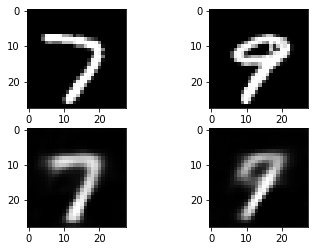

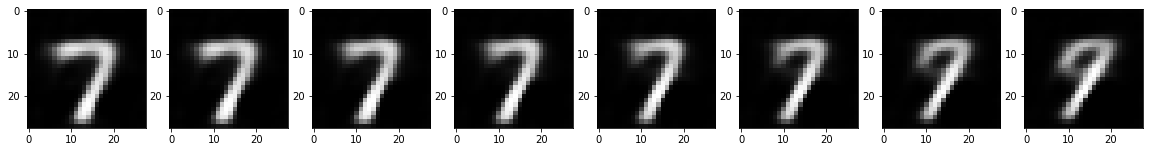

In [68]:
# Draw two samples (a 7 and a 9)
y_test_category = np.argmax(y_test,axis=1)
ix7 = np.where(y_test_category==7)[0][1]
ix9 = np.where(y_test_category==9)[0][1]
plt.subplot(221);plt.imshow(x_test[ix7,:].squeeze(),cmap='gray')
plt.subplot(222);plt.imshow(x_test[ix9,:].squeeze(),cmap='gray')

# Encoding: Calculate the latent representation of each sample
z7 = z_test[ix7,:]
z9 = z_test[ix9,:]

# Decoding: Reconstruct images from the two latent vectors
x_hat_7 = decoder.predict(z7.reshape(1,latent_dim))
x_hat_9 = decoder.predict(z9.reshape(1,latent_dim))

# Show reconstruction
plt.subplot(223);plt.imshow(x_hat_7.squeeze(),cmap='gray')
plt.subplot(224);plt.imshow(x_hat_9.squeeze(),cmap='gray')

N = 8
interp_features = np.zeros((N,latent_dim))
for i in range(latent_dim):
  interp_features[:,i] = np.linspace(z7[i].squeeze(),z9[i].squeeze(),N)

plt.figure(figsize=(20,6))
for i in range(N):
  x = interp_features[i,:].reshape(1,latent_dim)
  out = decoder.predict(x)
  plt.subplot(1,N,i+1)
  plt.imshow(out.squeeze(),cmap='gray')  

##5. Task 4: Generative Adversarial Networks
Below is an implementation of a Deep Convolutional GAN (DCGAN) for MNIST.

Code here: https://github.com/eriklindernoren/Keras-GAN/blob/master/dcgan/dcgan.py

###5.1 Recap of GANs
A DCGAN is a generative model that learns to map random noise vectors into images. Unlike an autoencoder, which  encodes and decodes an image into itself, DCGAN learns to generate images that look real. This means that you must have a data set of real images to compare with.

The network consists of two sub-networks that are trained in tandem:

- The **Generator** takes a random noise vector and maps it into an image.
- The **Discriminator** takes an input image, which is either **"real"** (i.e., picked from the database of real images) or **"fake"** (i.e., generated by the Generator). It then learns to distingiush between real and fake images.

The two networks are competing against each other, and at some point the Generator becomes so good at generating fakes, which look real, that the Discriminator can no longer distuingish fakes from reals.

GANs are really hard to train and the above example is just a toy example. The training loop looks like this:

![alt text](https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2019/05/Summary-of-the-Generative-Adversarial-Network-Training-Algorithm-1024x669.png)


###5.2 Your tasks
1. Run the code block to start training the model. In the meantime go through the code and see if you can identify the major steps of the training loop.

2. What is the dimensionality of the latent space in this example? Change it to 2 instead.

3. Extend the code such that you can train a DCGAN and subsequently make it generate images based on some 2D latent vector that you specify. Use this to make a plot of the 2D latent space, like we did above. What do you observe?

###Solution

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_135 (Conv2D)          (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_136 (Conv2D)          (None, 7, 7, 64)          18496     
_________________________________________________________________
zero_padding2d_8 (ZeroPaddin (None, 8, 8, 64)          0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 8, 8, 64)          256       
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 8, 8, 64)         

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.993686, acc.: 46.88%] [G loss: 0.808175]


<Figure size 432x288 with 0 Axes>

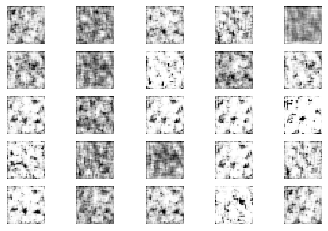

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


500 [D loss: 0.533994, acc.: 73.44%] [G loss: 1.550018]


<Figure size 432x288 with 0 Axes>

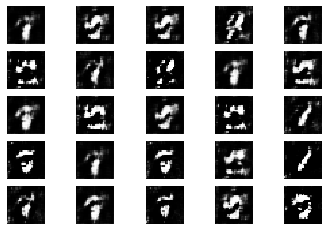

1000 [D loss: 0.654035, acc.: 60.94%] [G loss: 1.524740]


<Figure size 432x288 with 0 Axes>

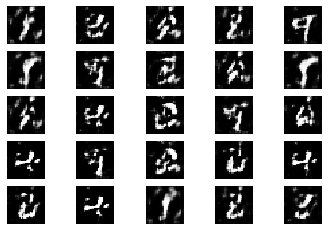

1500 [D loss: 0.624221, acc.: 62.50%] [G loss: 1.269840]


<Figure size 432x288 with 0 Axes>

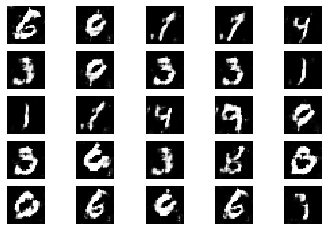

2000 [D loss: 0.597261, acc.: 70.31%] [G loss: 1.547251]


<Figure size 432x288 with 0 Axes>

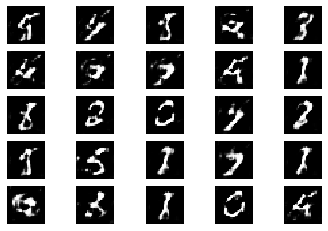

2500 [D loss: 0.538694, acc.: 71.88%] [G loss: 1.170877]


<Figure size 432x288 with 0 Axes>

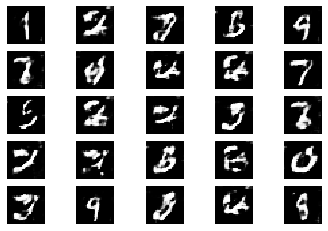

3000 [D loss: 0.614595, acc.: 67.19%] [G loss: 1.145685]


<Figure size 432x288 with 0 Axes>

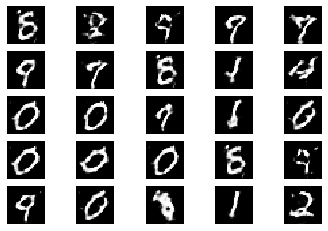

3500 [D loss: 0.601627, acc.: 68.75%] [G loss: 1.075804]


<Figure size 432x288 with 0 Axes>

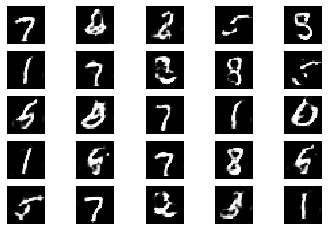

4000 [D loss: 0.639997, acc.: 65.62%] [G loss: 1.019084]


<Figure size 432x288 with 0 Axes>

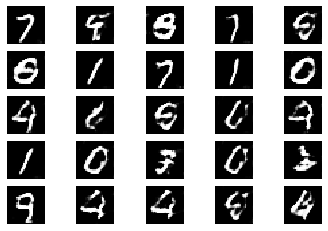

4500 [D loss: 0.632599, acc.: 70.31%] [G loss: 0.998728]


<Figure size 432x288 with 0 Axes>

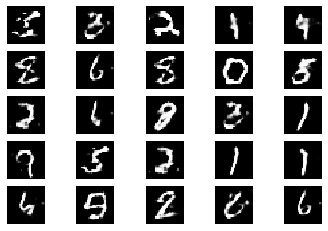

5000 [D loss: 0.787488, acc.: 50.00%] [G loss: 0.866333]


<Figure size 432x288 with 0 Axes>

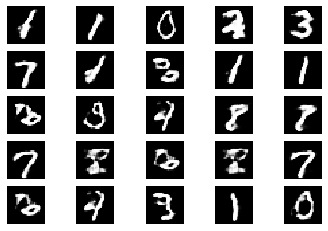

5500 [D loss: 0.640362, acc.: 59.38%] [G loss: 1.018969]


<Figure size 432x288 with 0 Axes>

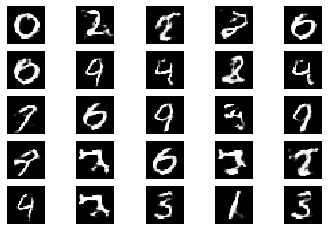

6000 [D loss: 0.563200, acc.: 76.56%] [G loss: 1.078800]


<Figure size 432x288 with 0 Axes>

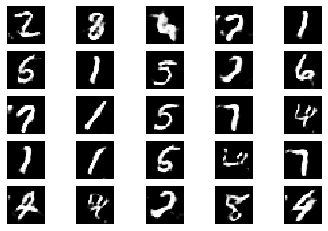

6500 [D loss: 0.808593, acc.: 45.31%] [G loss: 0.813500]


<Figure size 432x288 with 0 Axes>

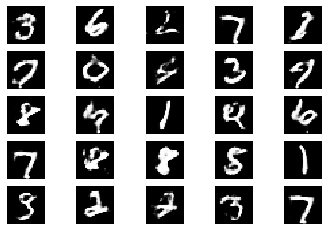

7000 [D loss: 0.548389, acc.: 68.75%] [G loss: 1.107801]


<Figure size 432x288 with 0 Axes>

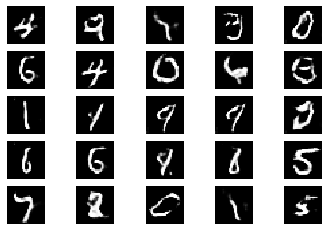

7500 [D loss: 0.493398, acc.: 76.56%] [G loss: 1.381352]


<Figure size 432x288 with 0 Axes>

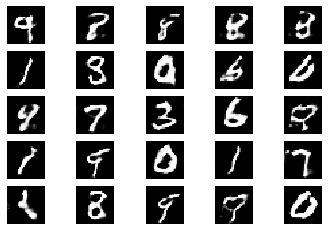

8000 [D loss: 0.539482, acc.: 76.56%] [G loss: 1.007890]


<Figure size 432x288 with 0 Axes>

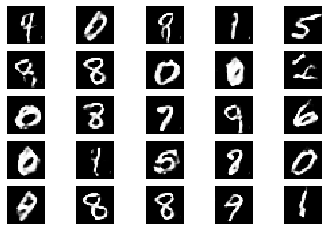

8500 [D loss: 0.542142, acc.: 65.62%] [G loss: 1.173242]


<Figure size 432x288 with 0 Axes>

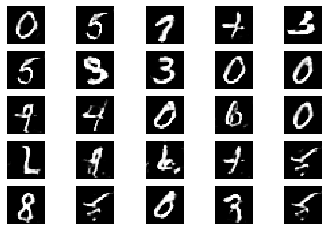

9000 [D loss: 0.589752, acc.: 64.06%] [G loss: 1.278023]


<Figure size 432x288 with 0 Axes>

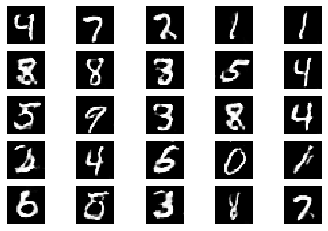

9500 [D loss: 0.635989, acc.: 60.94%] [G loss: 1.341820]


<Figure size 432x288 with 0 Axes>

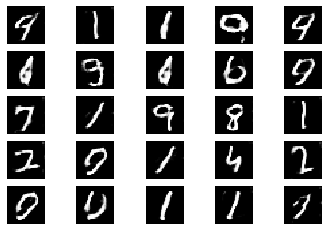

10000 [D loss: 0.609077, acc.: 65.62%] [G loss: 1.161901]


<Figure size 432x288 with 0 Axes>

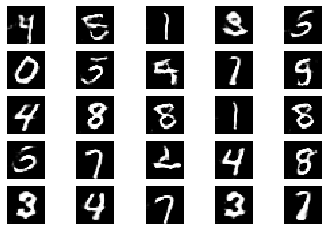

10500 [D loss: 0.582871, acc.: 65.62%] [G loss: 1.314325]


<Figure size 432x288 with 0 Axes>

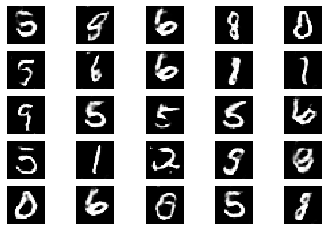

11000 [D loss: 0.441075, acc.: 82.81%] [G loss: 1.393218]


<Figure size 432x288 with 0 Axes>

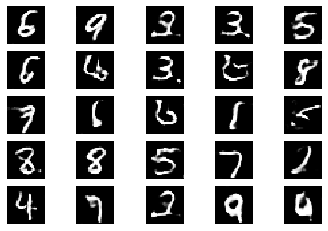

11500 [D loss: 0.606958, acc.: 62.50%] [G loss: 1.221164]


<Figure size 432x288 with 0 Axes>

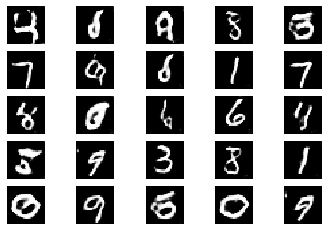

12000 [D loss: 0.549397, acc.: 68.75%] [G loss: 1.295409]


<Figure size 432x288 with 0 Axes>

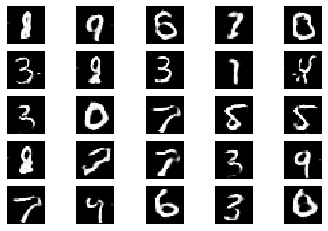

12500 [D loss: 0.591904, acc.: 68.75%] [G loss: 1.106834]


<Figure size 432x288 with 0 Axes>

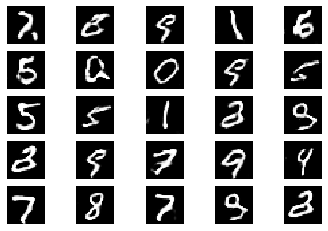

13000 [D loss: 0.355952, acc.: 89.06%] [G loss: 1.801735]


<Figure size 432x288 with 0 Axes>

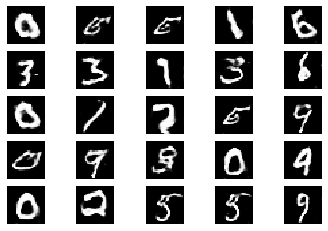

13500 [D loss: 0.582366, acc.: 76.56%] [G loss: 1.337512]


<Figure size 432x288 with 0 Axes>

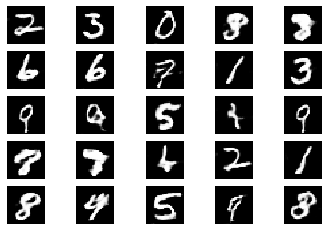

14000 [D loss: 0.443861, acc.: 79.69%] [G loss: 1.691382]


<Figure size 432x288 with 0 Axes>

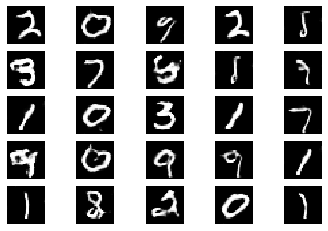

14500 [D loss: 0.496443, acc.: 73.44%] [G loss: 1.188710]


<Figure size 432x288 with 0 Axes>

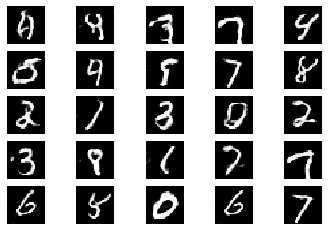

15000 [D loss: 0.486191, acc.: 73.44%] [G loss: 1.937036]


<Figure size 432x288 with 0 Axes>

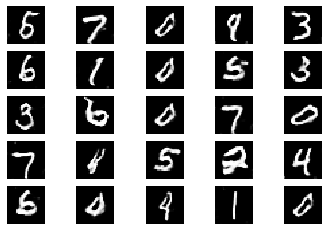

15500 [D loss: 0.420109, acc.: 82.81%] [G loss: 1.727929]


<Figure size 432x288 with 0 Axes>

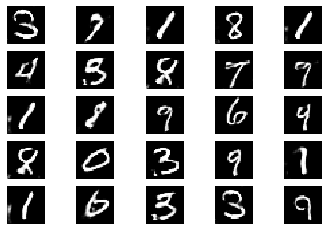

16000 [D loss: 0.569827, acc.: 73.44%] [G loss: 1.651504]


<Figure size 432x288 with 0 Axes>

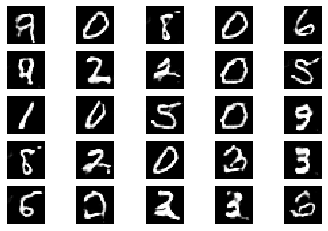

16500 [D loss: 0.570961, acc.: 70.31%] [G loss: 1.277631]


<Figure size 432x288 with 0 Axes>

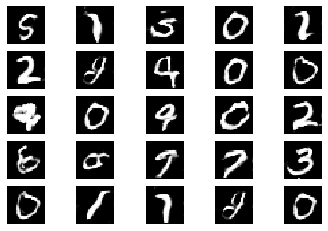

17000 [D loss: 0.489252, acc.: 76.56%] [G loss: 1.423226]


<Figure size 432x288 with 0 Axes>

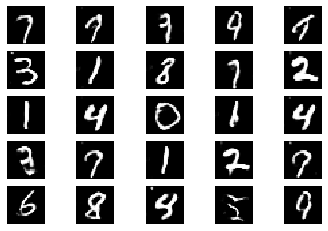

17500 [D loss: 0.553389, acc.: 68.75%] [G loss: 1.794552]


<Figure size 432x288 with 0 Axes>

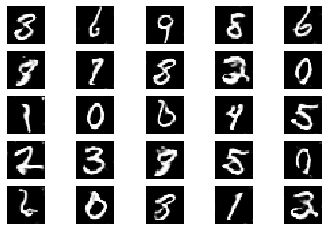

18000 [D loss: 0.428726, acc.: 81.25%] [G loss: 1.076550]


<Figure size 432x288 with 0 Axes>

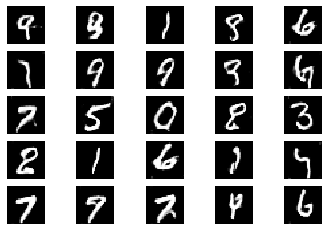

18500 [D loss: 0.328516, acc.: 89.06%] [G loss: 1.371092]


<Figure size 432x288 with 0 Axes>

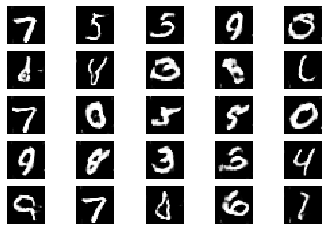

19000 [D loss: 0.402055, acc.: 85.94%] [G loss: 2.262992]


<Figure size 432x288 with 0 Axes>

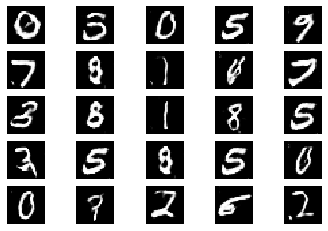

19500 [D loss: 0.410819, acc.: 82.81%] [G loss: 2.010322]


<Figure size 432x288 with 0 Axes>

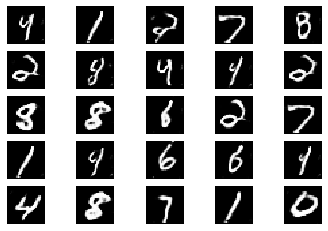

In [52]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt

import sys

class DCGAN():
    def __init__(self):
        # Input shape
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 2

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

        self.history = {}
        self.history['Dloss'] = []
        self.history['Dacc'] = []        
        self.history['Gloss'] = []

    def get_reconstruction(self,z_in):
      gen_imgs = self.generator.predict(z_in)
      return gen_imgs

    def build_generator(self):

        model = Sequential()

        model.add(Dense(128 * 7 * 7, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((7, 7, 128)))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(Conv2D(self.channels, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))

        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, save_interval=500):

        # Load the dataset
        (X_train, _), (_, _) = mnist.load_data()

        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            # Sample noise and generate a batch of new images
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Train the generator (wants discriminator to mistake images as real)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            #print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
                self.history['Dloss'].append(d_loss[0])
                self.history['Dacc'].append(d_loss[1])
                self.history['Gloss'].append(g_loss)
                self.save_imgs(epoch)

    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        plt.figure()
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        #fig.savefig("mnist_%d.png" % epoch)
        plt.show()

dcgan = DCGAN()
dcgan.train(epochs=20000, batch_size=32, save_interval=500)

###Show generated images on a uniform 2D grid:

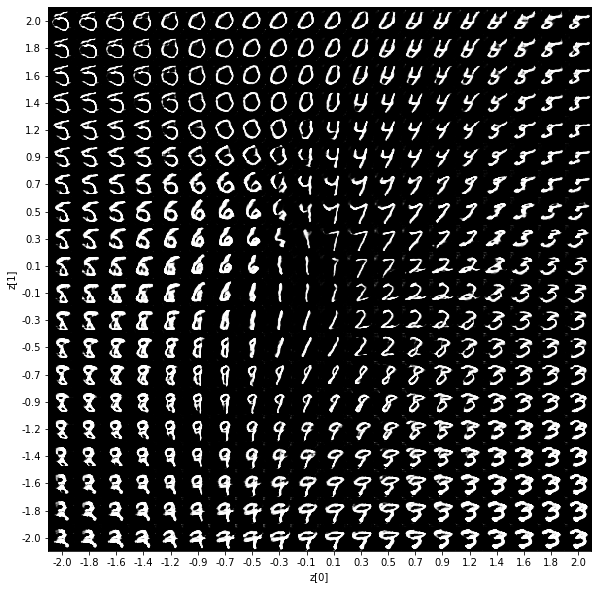

In [53]:
n = 20
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates corresponding to the 2D plot
# of digit classes in the latent space
grid_x = np.linspace(-2, 2, n)
grid_y = np.linspace(-2, 2, n)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = dcgan.get_reconstruction(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
                j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
start_range = digit_size // 2
end_range = n * digit_size + start_range + 1
pixel_range = np.arange(start_range, end_range, digit_size)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.imshow(figure, cmap='Greys_r')

###Plot loss

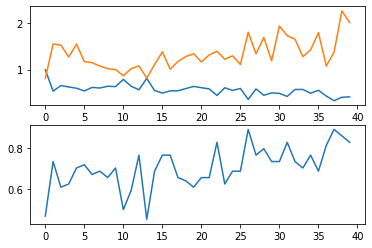

In [54]:
plt.subplot(211)
plt.plot(dcgan.history['Dloss'])
plt.plot(dcgan.history['Gloss'])
plt.subplot(212)
plt.plot(dcgan.history['Dacc'])

##5.3 Conditional GAN (optional)
The original GAN has no knowledge, and hence no understanding of the data's class labels. CGAN aims to solve this issue by telling both the generator and the discriminator what the class label is. Specifically, CGAN concatenates a one-hot vector y to the random noise vector z to result in an architecture that looks like this:

![alt text](https://paper-attachments.dropbox.com/s_D85DDA7D01FD04AEE96825C4B90F1126BC7D080CA4F2947D4A5DEC07FAD6122C_1559840765144_Screenshot+2019-06-06+at+10.35.29+PM.png)

If you have more time, try out the CGAN tutorial:

- https://github.com/eriklindernoren/Keras-GAN#cgan
- https://github.com/eriklindernoren/Keras-GAN/blob/master/cgan/cgan.py

How does it work?


Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_74 (Dense)             (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_53 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_75 (Dense)             (None, 512)               262656    
_________________________________________________________________
leaky_re_lu_54 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dropout_29 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_76 (Dense)             (None, 512)               262656    
_________________________________________________________________
leaky_re_lu_55 (LeakyReLU)   (None, 512)             

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.689561, acc.: 39.06%] [G loss: 0.685342]


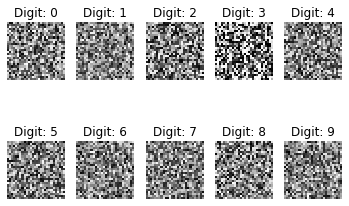

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


200 [D loss: 0.353345, acc.: 84.38%] [G loss: 2.742362]


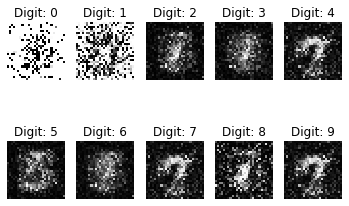

400 [D loss: 0.415257, acc.: 78.12%] [G loss: 2.383812]


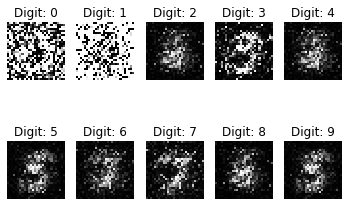

600 [D loss: 0.421172, acc.: 84.38%] [G loss: 2.344271]


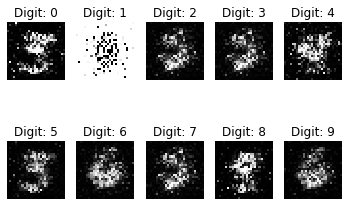

800 [D loss: 0.432037, acc.: 84.38%] [G loss: 2.541928]


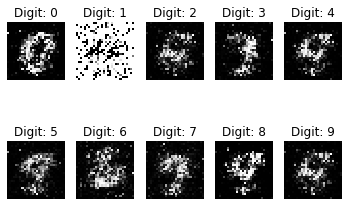

1000 [D loss: 0.527341, acc.: 70.31%] [G loss: 2.075423]


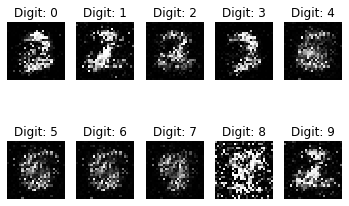

1200 [D loss: 0.477129, acc.: 79.69%] [G loss: 1.753567]


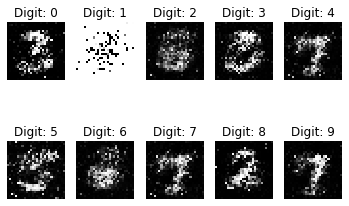

1400 [D loss: 0.467506, acc.: 75.00%] [G loss: 2.048864]


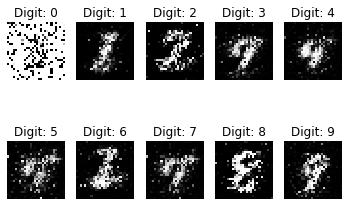

1600 [D loss: 0.458030, acc.: 73.44%] [G loss: 1.486786]


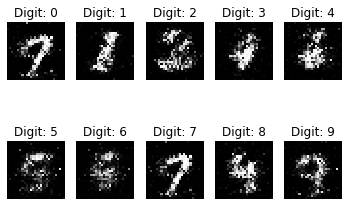

1800 [D loss: 0.467435, acc.: 78.12%] [G loss: 1.427114]


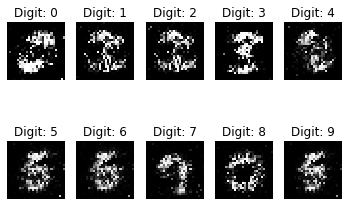

2000 [D loss: 0.511600, acc.: 79.69%] [G loss: 1.835104]


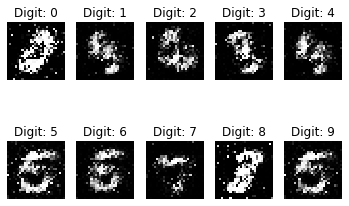

2200 [D loss: 0.411838, acc.: 85.94%] [G loss: 1.824968]


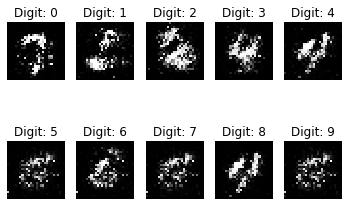

2400 [D loss: 0.519960, acc.: 71.88%] [G loss: 1.775152]


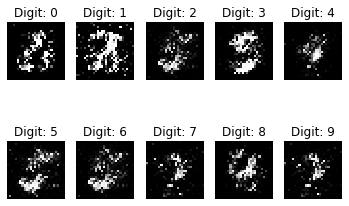

2600 [D loss: 0.496411, acc.: 75.00%] [G loss: 1.638286]


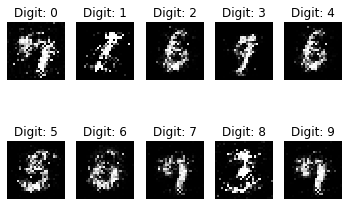

2800 [D loss: 0.414791, acc.: 85.94%] [G loss: 2.055328]


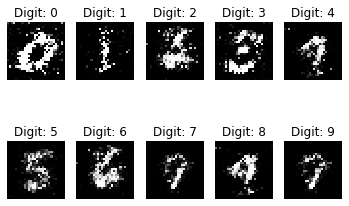

3000 [D loss: 0.537461, acc.: 71.88%] [G loss: 1.746507]


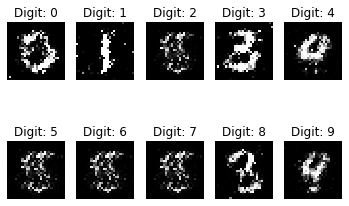

3200 [D loss: 0.484018, acc.: 78.12%] [G loss: 1.939710]


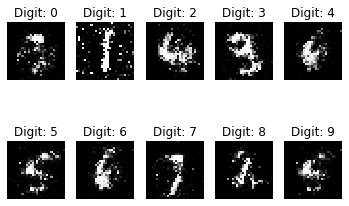

3400 [D loss: 0.316222, acc.: 89.06%] [G loss: 1.502761]


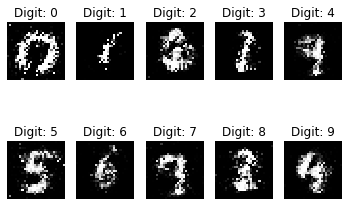

3600 [D loss: 0.352642, acc.: 84.38%] [G loss: 1.744455]


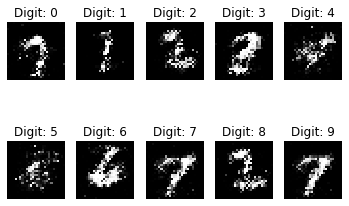

3800 [D loss: 0.431661, acc.: 78.12%] [G loss: 1.686766]


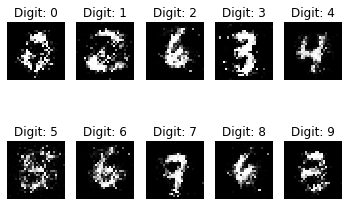

4000 [D loss: 0.447100, acc.: 82.81%] [G loss: 1.797166]


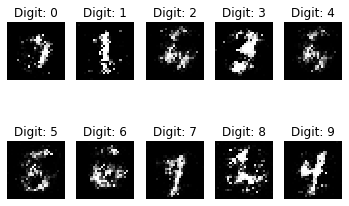

4200 [D loss: 0.481732, acc.: 76.56%] [G loss: 1.801133]


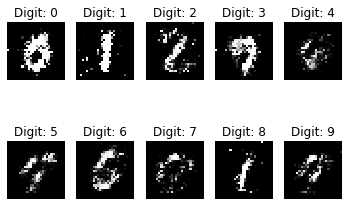

4400 [D loss: 0.445342, acc.: 78.12%] [G loss: 1.502310]


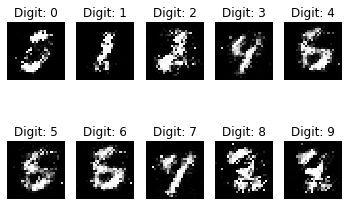

4600 [D loss: 0.362010, acc.: 85.94%] [G loss: 2.106192]


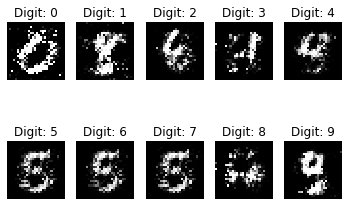

4800 [D loss: 0.356974, acc.: 85.94%] [G loss: 1.940031]


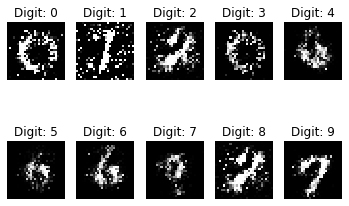

5000 [D loss: 0.407053, acc.: 84.38%] [G loss: 1.949702]


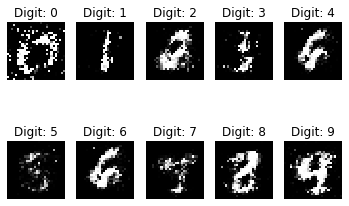

5200 [D loss: 0.301579, acc.: 85.94%] [G loss: 2.081367]


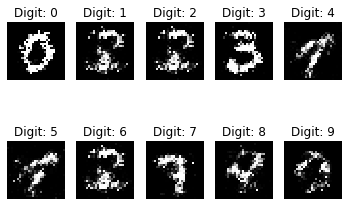

5400 [D loss: 0.348146, acc.: 85.94%] [G loss: 1.965166]


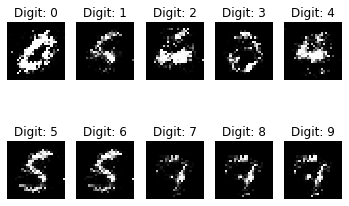

5600 [D loss: 0.430847, acc.: 85.94%] [G loss: 1.836660]


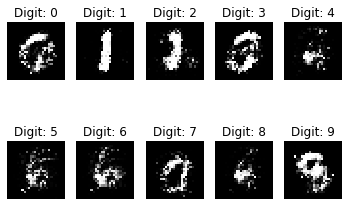

5800 [D loss: 0.449216, acc.: 81.25%] [G loss: 1.683007]


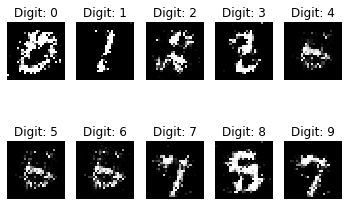

6000 [D loss: 0.314026, acc.: 85.94%] [G loss: 2.255774]


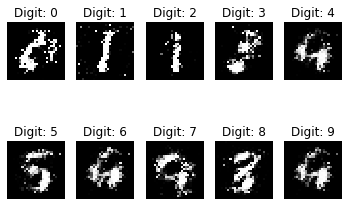

6200 [D loss: 0.347847, acc.: 84.38%] [G loss: 2.134826]


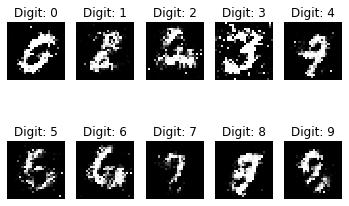

6400 [D loss: 0.263010, acc.: 92.19%] [G loss: 1.972243]


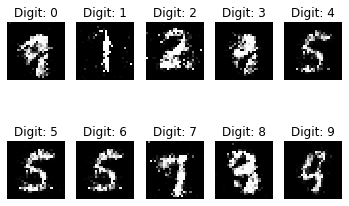

6600 [D loss: 0.323851, acc.: 90.62%] [G loss: 2.147043]


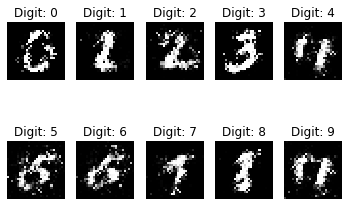

6800 [D loss: 0.328992, acc.: 89.06%] [G loss: 2.197732]


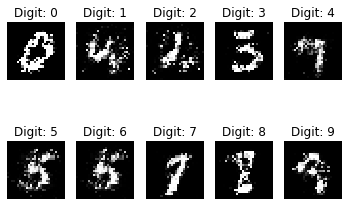

7000 [D loss: 0.399583, acc.: 81.25%] [G loss: 2.167565]


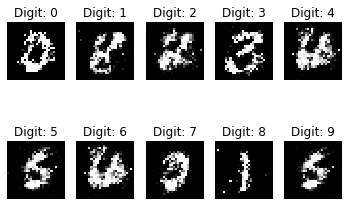

7200 [D loss: 0.336038, acc.: 89.06%] [G loss: 2.242887]


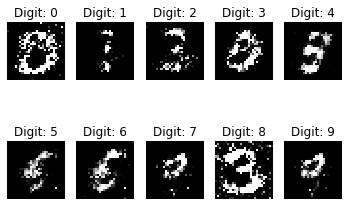

7400 [D loss: 0.230107, acc.: 92.19%] [G loss: 2.221752]


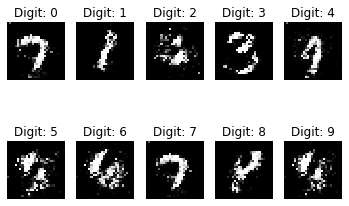

7600 [D loss: 0.527837, acc.: 73.44%] [G loss: 2.264204]


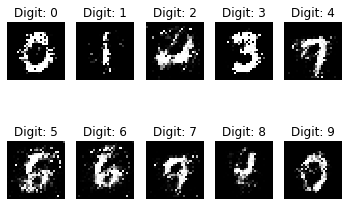

7800 [D loss: 0.271190, acc.: 90.62%] [G loss: 1.930200]


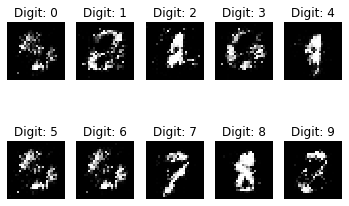

8000 [D loss: 0.389396, acc.: 89.06%] [G loss: 2.343643]


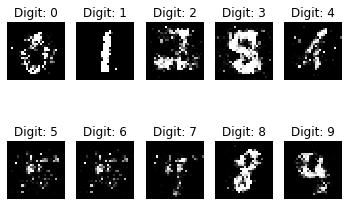

8200 [D loss: 0.207409, acc.: 95.31%] [G loss: 2.371112]


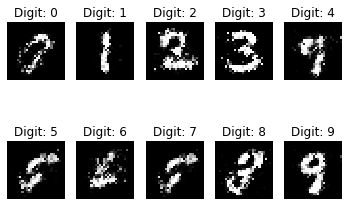

8400 [D loss: 0.353069, acc.: 82.81%] [G loss: 2.155175]


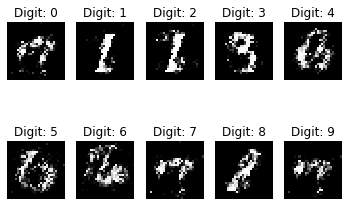

8600 [D loss: 0.419120, acc.: 76.56%] [G loss: 2.171144]


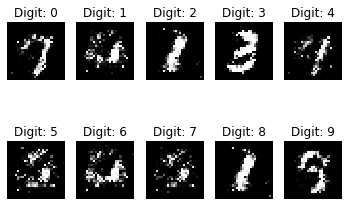

8800 [D loss: 0.132998, acc.: 96.88%] [G loss: 2.711407]


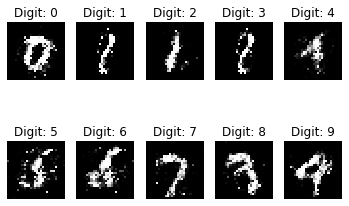

9000 [D loss: 0.330989, acc.: 89.06%] [G loss: 2.186807]


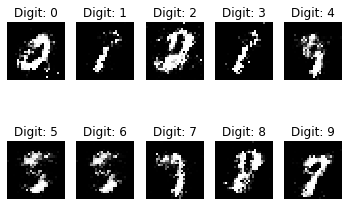

9200 [D loss: 0.397331, acc.: 79.69%] [G loss: 2.326231]


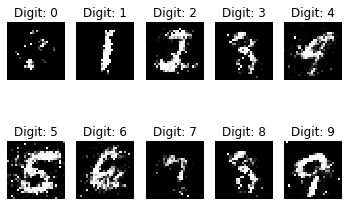

9400 [D loss: 0.313924, acc.: 89.06%] [G loss: 2.477035]


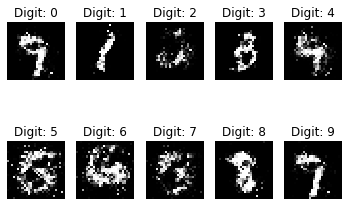

9600 [D loss: 0.372121, acc.: 81.25%] [G loss: 2.742263]


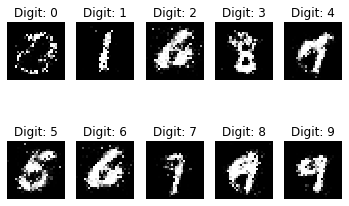

9800 [D loss: 0.216449, acc.: 92.19%] [G loss: 2.472415]


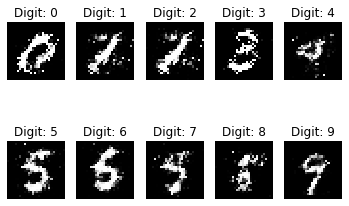

In [83]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt

import numpy as np

class CGAN():
    def __init__(self):
        # Input shape
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.num_classes = 10
        self.latent_dim = 2

        optimizer = Adam(0.0001, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss=['binary_crossentropy'],
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise and the target label as input
        # and generates the corresponding digit of that label
        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,))
        img = self.generator([noise, label])

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated image as input and determines validity
        # and the label of that image
        valid = self.discriminator([img, label])

        # The combined model  (stacked generator and discriminator)
        # Trains generator to fool discriminator
        self.combined = Model([noise, label], valid)
        self.combined.compile(loss=['binary_crossentropy'],
            optimizer=optimizer)

        self.history = {}
        self.history['Dloss'] = []
        self.history['Dacc'] = []        
        self.history['Gloss'] = []

    def get_reconstruction(self,z_in):
      gen_imgs = self.generator.predict(z_in)
      return gen_imgs

    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,), dtype='int32')
        label_embedding = Flatten()(Embedding(self.num_classes, self.latent_dim)(label))

        model_input = multiply([noise, label_embedding])
        img = model(model_input)

        return Model([noise, label], img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Dense(512, input_dim=np.prod(self.img_shape)))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        label = Input(shape=(1,), dtype='int32')

        label_embedding = Flatten()(Embedding(self.num_classes, np.prod(self.img_shape))(label))
        flat_img = Flatten()(img)

        model_input = multiply([flat_img, label_embedding])

        validity = model(model_input)

        return Model([img, label], validity)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        (X_train, y_train), (_, _) = mnist.load_data()

        # Configure input
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        X_train = np.expand_dims(X_train, axis=3)
        y_train = y_train.reshape(-1, 1)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs, labels = X_train[idx], y_train[idx]

            # Sample noise as generator input
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a half batch of new images
            gen_imgs = self.generator.predict([noise, labels])

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch([imgs, labels], valid)
            d_loss_fake = self.discriminator.train_on_batch([gen_imgs, labels], fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Condition on labels
            sampled_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1)

            # Train the generator
            g_loss = self.combined.train_on_batch([noise, sampled_labels], valid)

            # Plot the progress
            #print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
                self.history['Dloss'].append(d_loss[0])
                self.history['Dacc'].append(d_loss[1])
                self.history['Gloss'].append(g_loss)
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 2, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        sampled_labels = np.arange(0, 10).reshape(-1, 1)

        gen_imgs = self.generator.predict([noise, sampled_labels])

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt,:,:,0], cmap='gray')
                axs[i,j].set_title("Digit: %d" % sampled_labels[cnt])
                axs[i,j].axis('off')
                cnt += 1
        #fig.savefig("images/%d.png" % epoch)
        #plt.close()
        plt.show()

cgan = CGAN()
cgan.train(epochs=10000, batch_size=32, sample_interval=200)

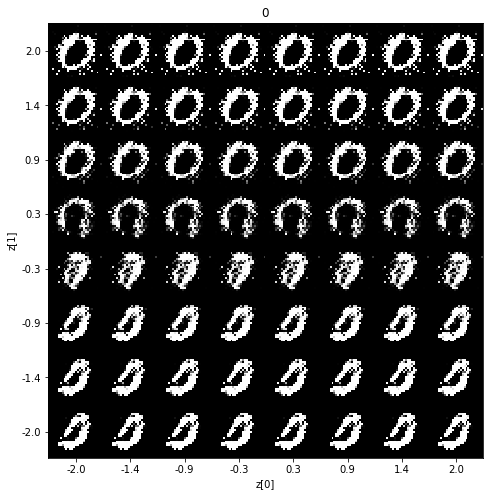

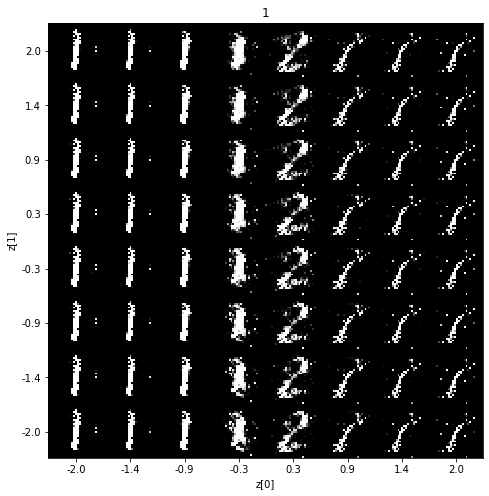

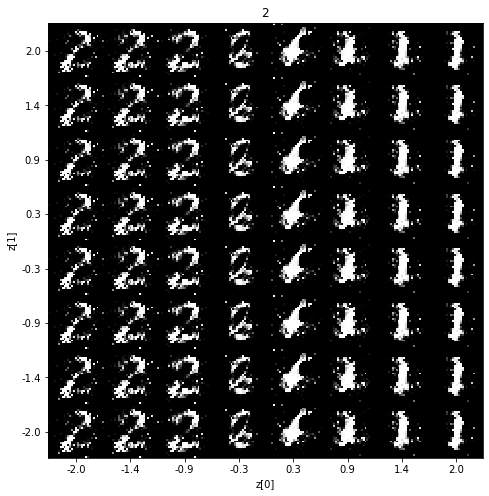

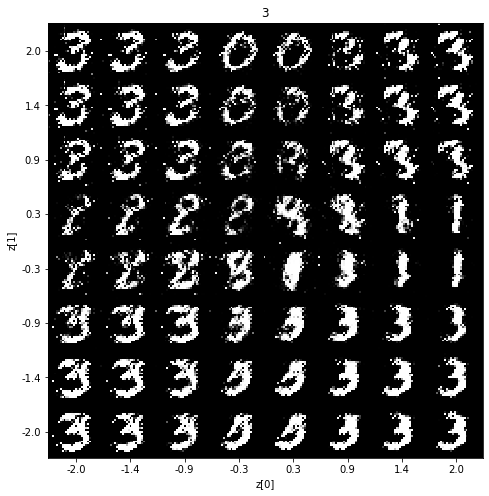

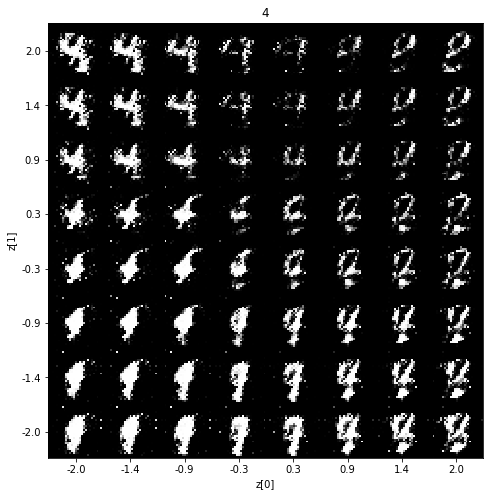

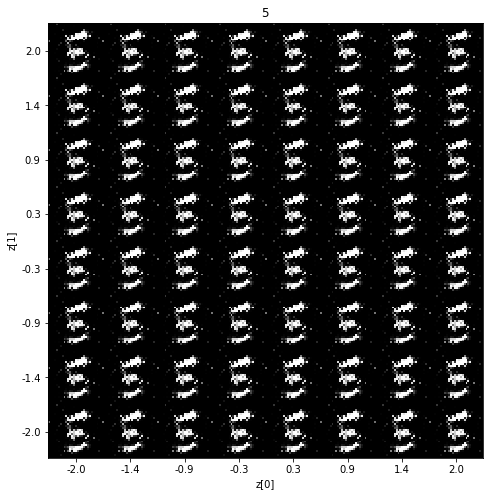

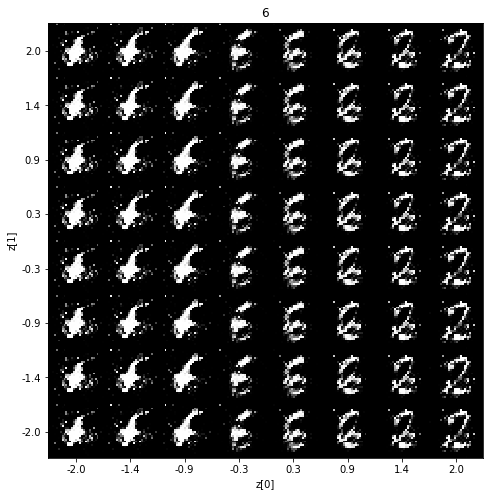

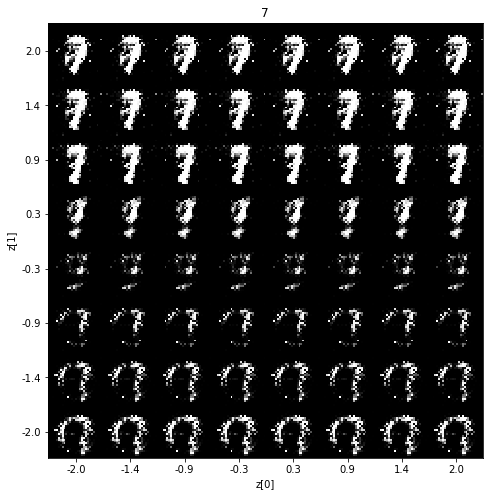

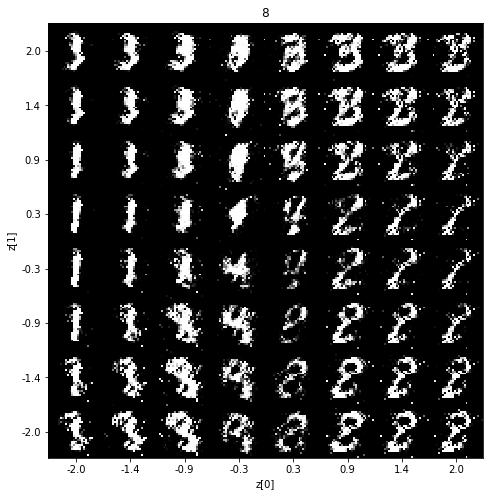

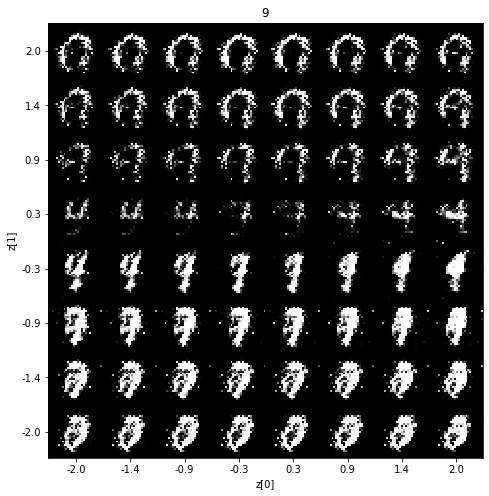

In [84]:
n = 8
digit_size = 28
for k in range(10):
  sampled_label = (np.ones(1)*k).reshape(-1, 1)
  figure = np.zeros((digit_size * n, digit_size * n))
  # linearly spaced coordinates corresponding to the 2D plot
  # of digit classes in the latent space
  grid_x = np.linspace(-2, 2, n)
  grid_y = np.linspace(-2, 2, n)[::-1]

  for i, yi in enumerate(grid_y):
      for j, xi in enumerate(grid_x):
          z_sample = np.array([[xi, yi]])
          x_decoded = cgan.get_reconstruction([z_sample, sampled_label])
          digit = x_decoded[0].reshape(digit_size, digit_size)
          digit = 0.5 * digit + 0.5
          figure[i * digit_size: (i + 1) * digit_size,
                  j * digit_size: (j + 1) * digit_size] = digit

  plt.figure(figsize=(8, 8))
  start_range = digit_size // 2
  end_range = n * digit_size + start_range + 1
  pixel_range = np.arange(start_range, end_range, digit_size)
  sample_range_x = np.round(grid_x, 1)
  sample_range_y = np.round(grid_y, 1)
  plt.xticks(pixel_range, sample_range_x)
  plt.yticks(pixel_range, sample_range_y)
  plt.xlabel("z[0]")
  plt.ylabel("z[1]")
  plt.imshow(figure, cmap='Greys_r')
  plt.title(str(k))

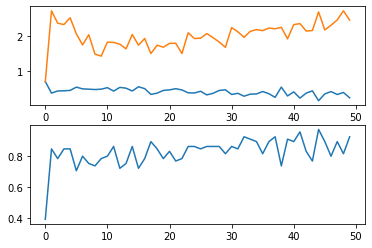

In [85]:
plt.subplot(211)
plt.plot(cgan.history['Dloss'])
plt.plot(cgan.history['Gloss'])
plt.subplot(212)
plt.plot(cgan.history['Dacc'])